# Accounting for Larmor-Scale Fluctuations

We want to quantify the effect Larmor-scale fluctuations have on the observed macroscopic values of $j_\nu$ or $\alpha_\nu$.  This file provides a sample procedure one could use to incorporate knowledge of the Larmor-scale structure of the magnetic field $\bf{B}$ and the electron number density $n_e$ in order to provide more accurate synchrotron emissivities and absorptivities.

First we need to specify the path of the symphony ${\tt /build/}$ folder.  Replace the path below with the correct path for your machine.

In [39]:
symphony_build_path = '/home/alex/Documents/Spring_2016/symphony/symphony/build'

The next cell will import all of the necessary libraries (including symphony).  It will also set some matplotlib plot parameters to make nice-looking plots.

In [40]:
%matplotlib inline

#import symphony to use exact integrator or fitting formulae
import sys
sys.path.append(symphony_build_path)
import symphonyPy as sp

#import other useful libraries
import numpy as np
import pylab as pl
import numpy.random as random
from numpy.random import normal
import scipy.special as special
from scipy.interpolate import splrep, splev, interp1d
from statsmodels.nonparametric.kde import KDEUnivariate
from scipy.stats.distributions import norm
from scipy.optimize import curve_fit

# Set plot parameters to make beautiful plots
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

## Importing Data

The following two cells deal with importing the simulation data.  In the first, choose the path to the folder containing the data files.  The value of num_skip determines the number of data points sampled from the data files; for example, $\tt{num\_skip = 32}$ will sample every 32nd point from the data files.  To sample every point, choose $\tt{num\_skip = 1}$.  By default, the magnetic field is normalized to its initial value from the start of the simulation; it can be scaled to a value in Gauss by setting $\tt{B\_scale}$.  Finally, there is a place to choose the value of $\bf{k}$; this is the direction from which the observer is looking at the simulation plane (which is the x-y plane).  $\bf{k}$ does not have to be normalized.

In [68]:
datafiles_path = '/home/alex/Documents/Spring_2016/'

num_skip = 32
B_scale  = 30.
obs_vector = [1, 0, 0] #choose observer vector; does not have to be normalized (normalization taken care of below)

In [70]:
#import data

#datafiles_path = '/home/mani/work/kunz_data/'
B_x = np.loadtxt(datafiles_path + 'mirror_bx.out')[::num_skip, ::num_skip] * B_scale
B_y = np.loadtxt(datafiles_path + 'mirror_by.out')[::num_skip, ::num_skip] * B_scale
B_z = np.loadtxt(datafiles_path + 'mirror_bz.out')[::num_skip, ::num_skip] * B_scale
n_e = np.loadtxt(datafiles_path + 'mirror_d.out')[::num_skip, ::num_skip]
B_mag = np.sqrt(B_x**2. + B_y**2. + B_z**2.)

obs_angle  = np.zeros(np.shape(B_x))
for i in range(0, np.shape(B_x)[0]):
    for j in range(0, np.shape(B_x)[1]):
        B_vector = [B_x[j][i], B_y[j][i], B_z[j][i]]
        obs_angle[j][i] = np.arccos(np.dot(B_vector, obs_vector) / (np.linalg.norm(B_vector) * np.linalg.norm(obs_vector)))

## Analyzing $B$, $\theta$, $n_e$ Distributions

In order to produce averaged emissivities and absorptivities which take Larmor-scale fluctuations into account, we first need to understand the distributions of the fluctuating quantities $B$ (the magnitude of the magnetic field) $\theta$ (the observer angle) and $n_e$ (the electron number density).

### The $\theta$ Distribution

The observer angle $\theta$ is defined to be the angle between the wavevector $\bf{k}$ and the local magnetic field $\bf{B}$.  The distribution of $\theta$ is nearly a Gaussian.  The code below fits the mean and standard deviation of this Gaussian and plots the fit along with the data itself.

Fitted mean               =  0.975332004086
Fitted standard deviation =  0.140546615055


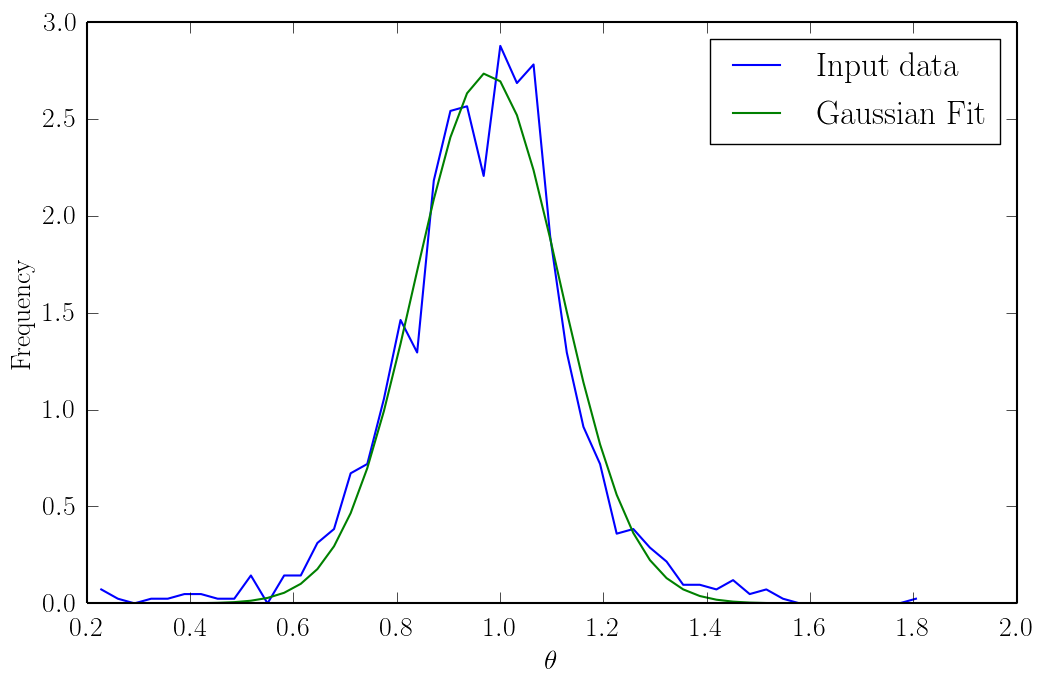

In [73]:
#fit Gaussian probability distribution to obs_angle distribution
data = obs_angle.flatten()
hist, bin_edges = np.histogram(data, density=True, bins=50)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 0., 1.]

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

# Get the fitted curve
hist_fit = gauss(bin_centres, *coeff)

pl.plot(bin_centres, hist, label='$\\mathrm{Input~data}$')
pl.plot(bin_centres, hist_fit, label='$\\mathrm{Gaussian~Fit}$')
pl.xlabel('$\\theta$')
pl.ylabel('$\\mathrm{Frequency}$')

fit_mu    = coeff[1]
fit_sigma = coeff[2]

# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print 'Fitted mean               = ', fit_mu
print 'Fitted standard deviation = ', fit_sigma 
pl.legend()
pl.show()

### The $B$ Distribution

The distribution of the magnitude of the magnetic field $B$ is bimodal in this case and not easily fit by any standard distribution function.  We can achieve an approximation to the true $B$ distribution in this case using a Kernel Density Estimation (KDE) algorithm.   

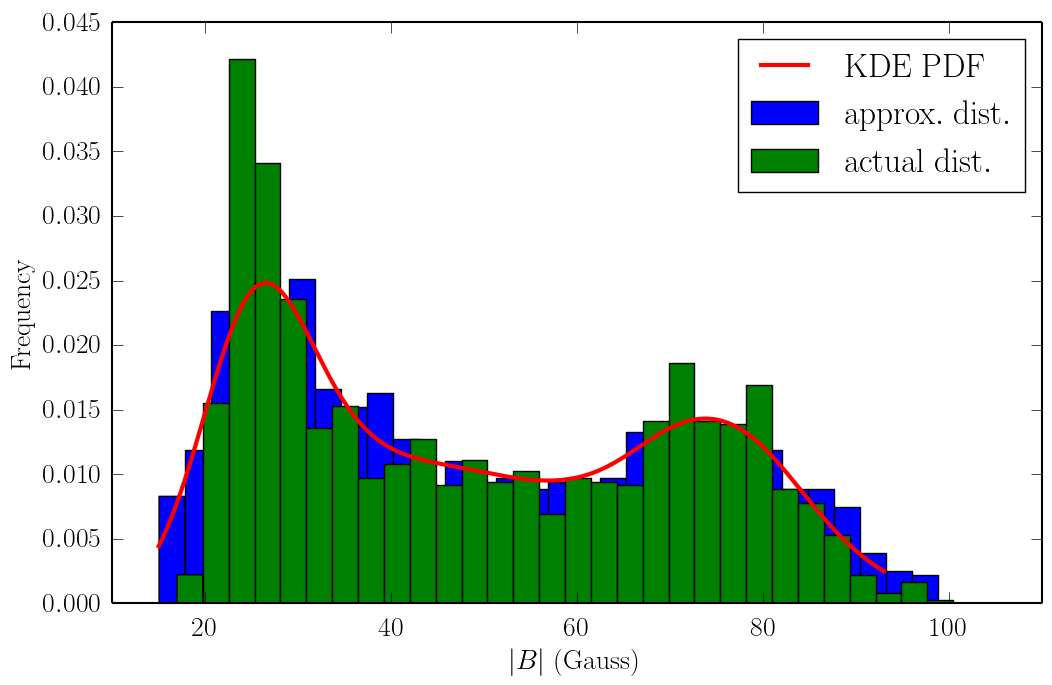

In [75]:
def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)

#num_skip = 32
#B_scale  = 30.

#B_x = np.loadtxt(datafiles_path + 'mirror_bx.out')[::num_skip, ::num_skip] * B_scale
#B_y = np.loadtxt(datafiles_path + 'mirror_by.out')[::num_skip, ::num_skip] * B_scale
#B_z = np.loadtxt(datafiles_path + 'mirror_bz.out')[::num_skip, ::num_skip] * B_scale
#B_mag = np.sqrt(B_x**2. + B_y**2. + B_z**2.)
from scipy.interpolate import splrep, splev, interp1d
# The grid we'll use for plotting
min_x = 15.
max_x = 93.
num_points = 1000
x_grid = np.linspace(min_x, max_x, num_points)

bandwith_set = 5.

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = B_mag.flatten()

pdf = kde_statsmodels_u(x, x_grid, bandwidth=bandwith_set)

width_of_step = (max_x - min_x) / num_points
cdf = np.cumsum(pdf) * width_of_step
tck = splrep(x_grid, cdf)
tck_inv = splrep(cdf, x_grid)

#need to remove erroneous values of approximate_dist that are greater than max(B_mag)
approximate_dist = splev(np.random.rand(1296+17, 1).flatten(), tck_inv)
approximate_dist = approximate_dist[approximate_dist < np.amax(B_mag)]
#print np.amax(approximate_dist)

pl.hist(approximate_dist, bins=30, normed=True, label='$\\mathrm{approx.~dist.}$');
pl.hist(B_mag.flatten(),  bins=30, normed=True, label='$\\mathrm{actual~dist.}$');
pl.plot(x_grid, pdf, linewidth=3, label='$\\mathrm{KDE~PDF}$')
pl.legend(loc='upper right')
pl.xlabel('$|B|\\mathrm{~(Gauss)}$')
pl.ylabel('$\\mathrm{Frequency}$')

#print np.size(B_mag.flatten())
#print np.size(approximate_dist)

### The $n_e$ Distribution

The distribution of electron number density across the simulation is very nearly constant, with variations on the order of 1%.  The cell below plots $n_e$ to illustrate this point.  Since the fluctuations in $n_e$ are so small, we can simply use its spatially-averaged value (which is equivalent to using a uniform distribution at this value).

<matplotlib.colorbar.Colorbar instance at 0x7ffa3ecd91b8>

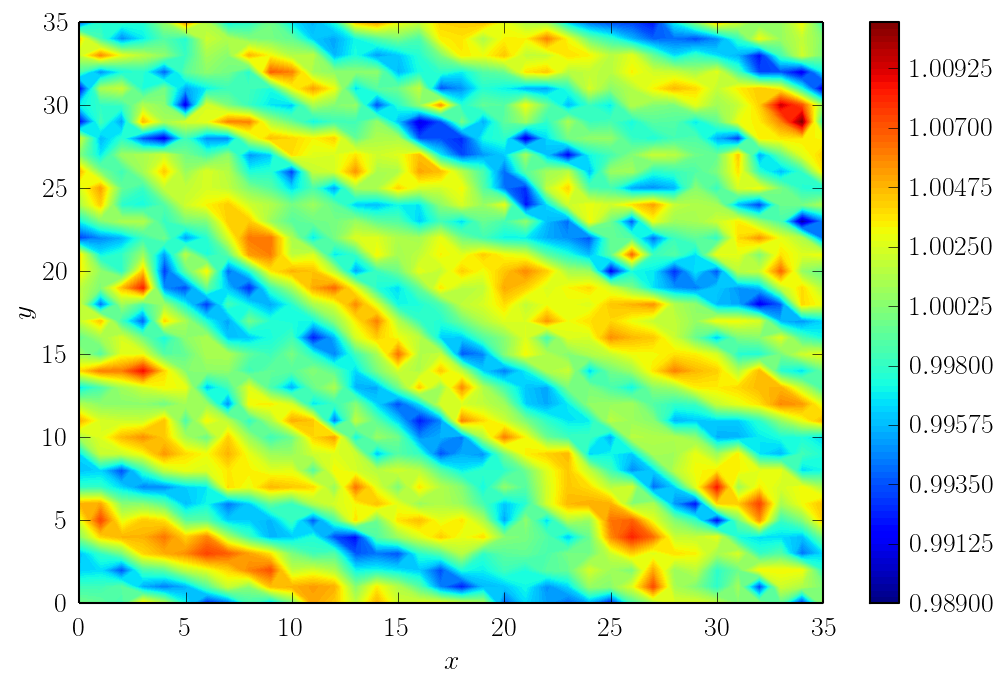

In [80]:
pl.contourf(n_e, 100)
pl.xlabel('$x$')
pl.ylabel('$y$')
pl.colorbar()

## Testing the Various Approximations

Now we will check the effect the various approximations ($\theta$ as a Gaussian, our $B$ KDE fit, and a uniform distribution for $n_e$) have on the emissivities and absorptivities as calculated by symphony.  The first cell below contains parameters to be set, such as $\tt{emiss}$ which will have symphony calculate $j_\nu$ if $\tt{emiss} = True$; otherwise it will calculate $\alpha_\nu$.  

In [89]:
#set symphony's parameters

#calculates j_nu if True, alpha_nu if false
emiss            = True

#choose frequency nu in Hz
nu = 230e9

#do not change stokes parameter for now; still need to correct STOKES_Q/STOKES_U with transformation
stokes_parameter = sp.STOKES_I

#sp.POWER_LAW, sp.MAXWELL_JUETTNER, or sp.KAPPA_DIST
distribution     = sp.POWER_LAW

#dimensionless electron temperature for MAXWELL_JUETTNER (thermal) distribution
theta_e          = 10.

#parameters for the power-law distribution (index is p)
gamma_min        = 1.
gamma_max        = 1000.
gamma_cutoff     = 1e10
p                = 3.

#parameters for the kappa distribution
kappa            = 3.5
w                = 10.

In [90]:
#define constants in Gaussian CGS units
m         = 9.1093826e-28
c         = 2.99792458e10
e         = 4.80320680e-10
h         = 6.6260693e-27


#all emissivities have a dimensional prefactor times a dimensionless term;
#norm is the dimensional term; divide the emissivites by norm to get dimensionless results

norm_j_nu = np.mean(n_e) * e**2. * (e * np.mean(B_mag) / (2. * np.pi * m * c)) / c
norm_alpha_nu = np.mean(n_e) * e**2. / (nu * m * c)

#a wrapper for symphony's fitting formulae function
def j_nu_or_alpha_nu(nu, obs_angle, B_mag, n_e):
    if emiss == True:
        return np.vectorize(sp.j_nu_fit_py)(nu, B_mag, n_e, obs_angle, distribution, 
                              stokes_parameter, theta_e, p, gamma_min, 
                              gamma_max, gamma_cutoff, kappa, w) / norm_j_nu
    else:
        return sp.alpha_nu_fit_py(nu, B_mag, n_e, obs_angle, distribution, 
                                  stokes_parameter, theta_e, p, gamma_min, 
                                  gamma_max, gamma_cutoff, kappa, w) / norm_alpha_nu

The cell beow will calculate the relative difference

In [91]:
#We now want to calculate j_nu() using theta sampled from an approximation to its
# actual distribution (a Gaussian).  We want to do the same with the distribution
# of |B|, though before we do that we need to figure out how to randomly sample
# numbers from the KDE approximate PDF for |B|.

size = len(obs_angle.flatten())
n_e_avg = np.mean(n_e)
mean_B_vector = [np.mean(B_x), np.mean(B_y), np.mean(B_z)]
angle_to_mean_field = np.arccos(np.dot(mean_B_vector, obs_vector) / (np.linalg.norm(mean_B_vector) * np.linalg.norm(obs_vector)))


obs_angle_approx_samples = np.random.normal(fit_mu, fit_sigma, size)

j_nu_exact           = np.mean(j_nu_or_alpha_nu(nu, obs_angle.flatten(), B_mag.flatten(), n_e.flatten()))
j_nu_avgs            = j_nu_or_alpha_nu(nu, angle_to_mean_field, np.mean(B_mag), np.mean(n_e))
j_nu_approx_theta    = np.mean(j_nu_or_alpha_nu(nu, obs_angle_approx_samples, B_mag.flatten(), n_e.flatten()))
j_nu_approx_theta_ne = np.mean(j_nu_or_alpha_nu(nu, obs_angle_approx_samples, B_mag.flatten(), n_e_avg))
j_nu_approx_B        = np.mean(j_nu_or_alpha_nu(nu, obs_angle.flatten(), approximate_dist, n_e.flatten()))
j_nu_approx_B_ne     = np.mean(j_nu_or_alpha_nu(nu, obs_angle.flatten(), approximate_dist, n_e_avg))

j_nu_approx_all      = np.mean(j_nu_or_alpha_nu(nu, obs_angle_approx_samples, approximate_dist, n_e_avg))

print 'Exact: ', j_nu_exact, ' Avgs:              ', j_nu_avgs,            ' Error: ', (j_nu_exact - j_nu_avgs)           / j_nu_exact
print 'Exact: ', j_nu_exact, ' approx theta:      ', j_nu_approx_theta,    ' Error: ', (j_nu_exact - j_nu_approx_theta)   / j_nu_exact
print 'Exact: ', j_nu_exact, ' approx theta, n_e: ', j_nu_approx_theta_ne, ' Error: ', (j_nu_exact - j_nu_approx_theta_ne)/ j_nu_exact
print 'Exact: ', j_nu_exact, ' approx B:          ', j_nu_approx_B,        ' Error: ', (j_nu_exact - j_nu_approx_B)       / j_nu_exact
print 'Exact: ', j_nu_exact, ' approx B, n_e:     ', j_nu_approx_B_ne,     ' Error: ', (j_nu_exact - j_nu_approx_B_ne)    / j_nu_exact
print 'Exact: ', j_nu_exact, ' approx all:        ', j_nu_approx_all,      ' Error: ', (j_nu_exact - j_nu_approx_all)    / j_nu_exact

Exact:  0.00103712475407  Avgs:               0.000861732506108  Error:  0.169113934722
Exact:  0.00103712475407  approx theta:       0.00101277201519  Error:  0.0234810120786
Exact:  0.00103712475407  approx theta, n_e:  0.00101519302372  Error:  0.0211466655853
Exact:  0.00103712475407  approx B:           0.00102371784792  Error:  0.0129269946507
Exact:  0.00103712475407  approx B, n_e:      0.00102388754081  Error:  0.0127633760607
Exact:  0.00103712475407  approx all:         0.0010438548036  Error:  -0.00648914174441


In [32]:
#Demonstrate which quantity's fluctuations have the greatest effect on the error.
# This example shows that it is B_mag for observer vectors that produce most
# emission / absorption.

j_nu_exact = np.mean(pl_I(nu, obs_angle.flatten(), B_mag.flatten(), n_e.flatten()))
avg_B_only = np.mean(pl_I(nu, obs_angle.flatten(), np.mean(B_mag.flatten()), n_e.flatten()))
avg_t_only = np.mean(pl_I(nu, np.mean(obs_angle.flatten()), B_mag.flatten(), n_e.flatten()))
avg_n_only = np.mean(pl_I(nu, obs_angle.flatten(), B_mag.flatten(), np.mean(n_e.flatten())))

print 'Exact: ', j_nu_exact/norm, ' Exact theta, n_e; avg B:     ', avg_B_only/norm,     ' Error: ', (j_nu_exact - avg_B_only)    / j_nu_exact
print 'Exact: ', j_nu_exact/norm, ' Exact B, n_e; avg theta:     ', avg_t_only/norm,     ' Error: ', (j_nu_exact - avg_t_only)    / j_nu_exact
print 'Exact: ', j_nu_exact/norm, ' Exact B, theta; avg n_e:     ', avg_n_only/norm,     ' Error: ', (j_nu_exact - avg_n_only)    / j_nu_exact

Exact:  0.00103712475407  Exact theta, n_e; avg B:      0.000834939773339  Error:  0.194947599056
Exact:  0.00103712475407  Exact B, n_e; avg theta:      0.00101103834575  Error:  0.0251526233563
Exact:  0.00103712475407  Exact B, theta; avg n_e:      0.00103969379737  Error:  -0.00247708223388
